# House Price Prediction using Machine Learning

**Author:** Hope Khashab
**Date:** December 2024

## Project Overview
This project predicts house prices using machine learning regression models. I compare Linear Regression and Random Forest algorithms on the Ames Housing dataset to identify which features most influence home values.

## Business Question
Can we accurately predict house sale prices based on features like quality, size, and age?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('train.csv')

# First look
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1460, 81)

First few rows:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Price range: $34,900 to $755,000


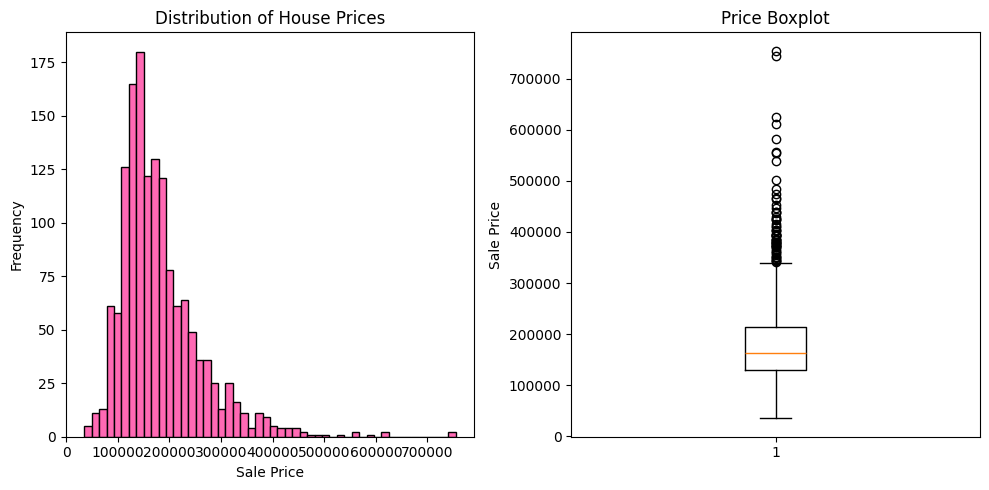

In [3]:
# Price distribution
print(df['SalePrice'].describe())
print(f"\nPrice range: ${df['SalePrice'].min():,.0f} to ${df['SalePrice'].max():,.0f}")

# Visualize price distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(df['SalePrice'], bins=50, color='#FF69B4', edgecolor='black')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')

plt.subplot(1, 2, 2)
plt.boxplot(df['SalePrice'], vert=True)
plt.ylabel('Sale Price')
plt.title('Price Boxplot')
plt.tight_layout()
plt.show()

In [4]:
# Missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Features with missing values:")
print(missing)
print(f"\nTotal features with missing data: {len(missing)}")

Features with missing values:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

Total features with missing data: 19


In [5]:
# Correlation with price
numeric_features = df.select_dtypes(include=[np.number]).columns
correlations = df[numeric_features].corr()['SalePrice'].sort_values(ascending=False)
print("Top 10 features correlated with SalePrice:")
print(correlations.head(11))  # 11 because SalePrice correlates with itself

Top 10 features correlated with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


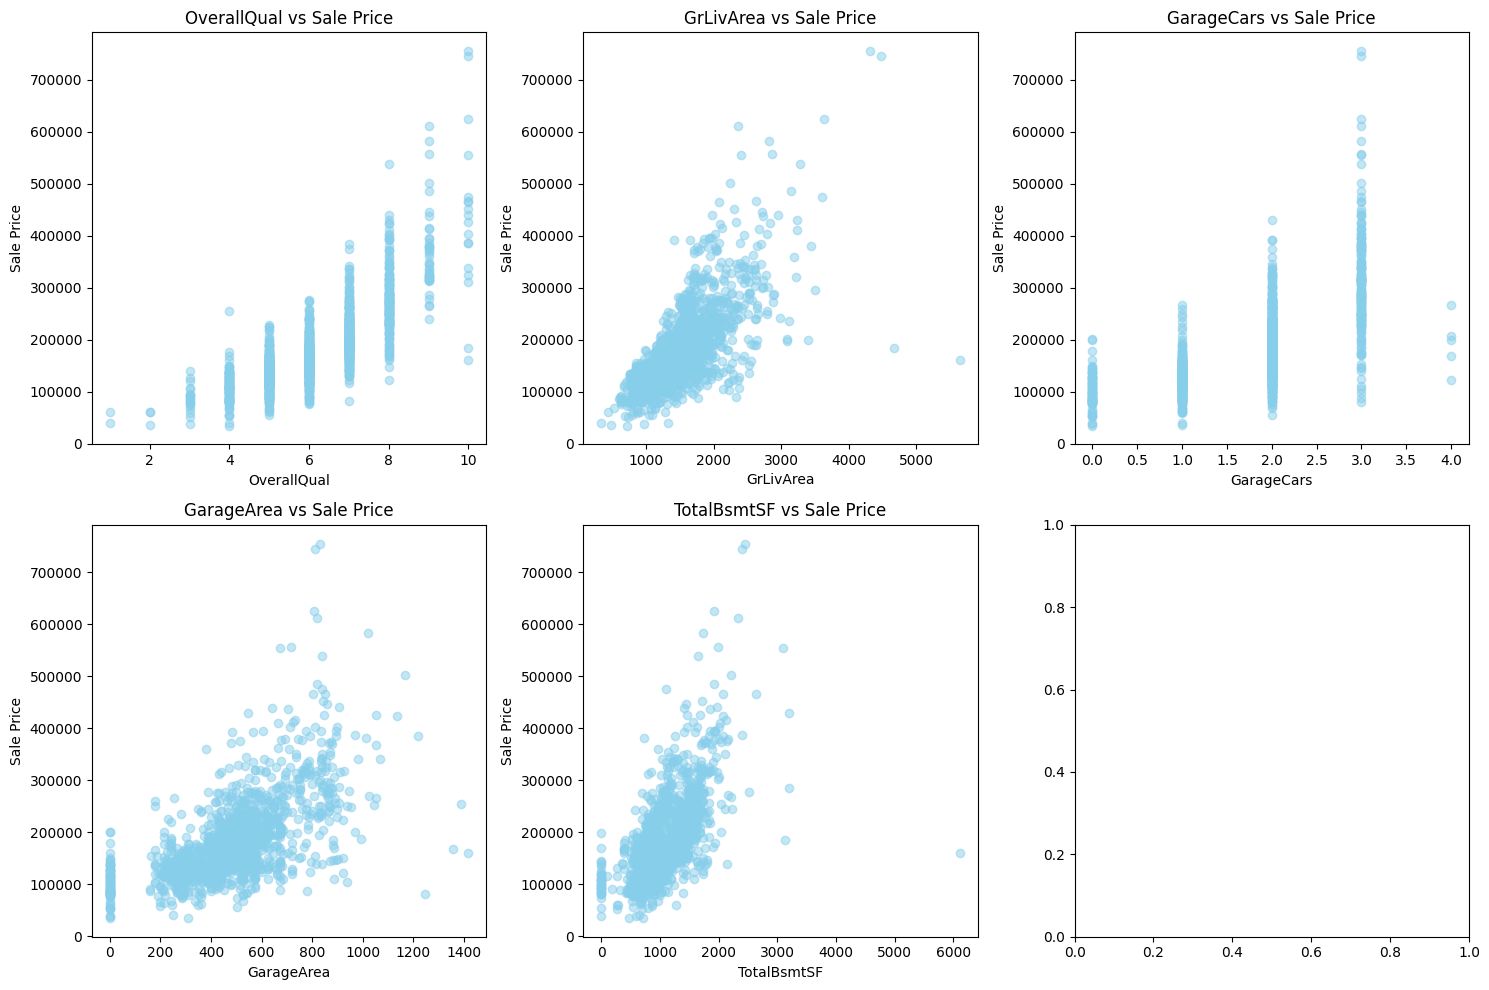

In [6]:
# Look at top correlated features with price
top_features = correlations.head(6).index[1:]  # Exclude SalePrice itself

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    axes[i].scatter(df[feature], df['SalePrice'], alpha=0.5, color='#87CEEB')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Sale Price')
    axes[i].set_title(f'{feature} vs Sale Price')

plt.tight_layout()
plt.show()

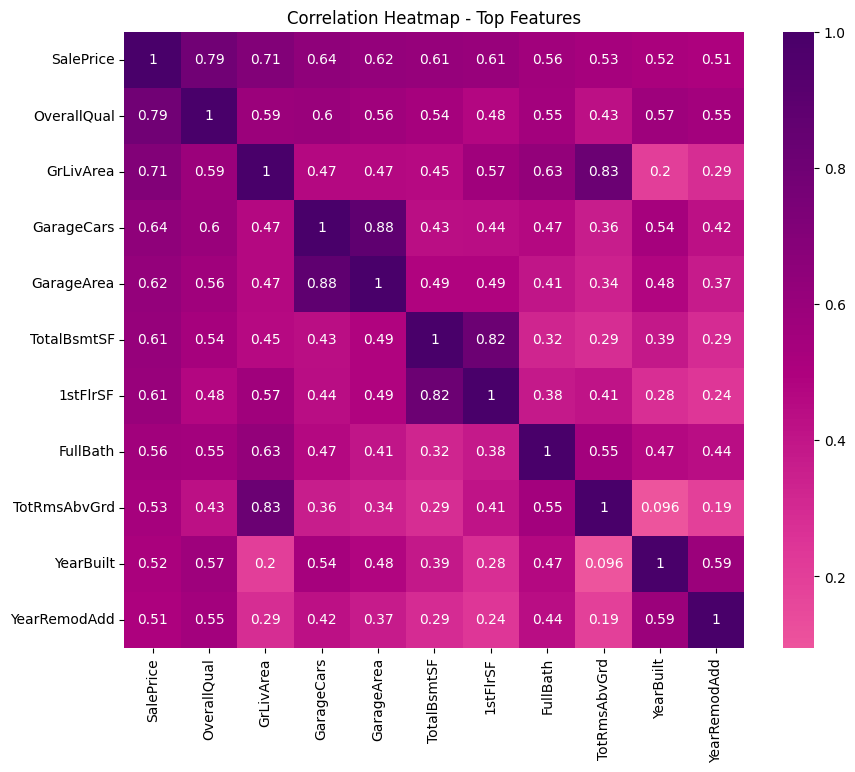

In [7]:
# Heatmap of top correlated features
top_10_features = correlations.head(11).index
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_10_features].corr(), annot=True, cmap='RdPu', center=0)
plt.title('Correlation Heatmap - Top Features')
plt.show()

In [8]:
# Top 5 features correlated with SalePrice (excluding SalePrice itself)
print("Top 5 features most correlated with Sale Price:\n")
print(correlations.head(6)[1:])  # [1:] skips SalePrice correlating with itself

Top 5 features most correlated with Sale Price:

OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64


In [9]:
# Missing data in our top features
print("Missing values in top features:")
for feature in ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']:
    missing_count = df[feature].isnull().sum()
    print(f"{feature}: {missing_count}")

Missing values in top features:
OverallQual: 0
GrLivArea: 0
GarageCars: 0
GarageArea: 0
TotalBsmtSF: 0


In [10]:
# Prep data for modeling

features_to_use = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
    'FullBath', 'YearBuilt', 'YearRemodAdd'
]

# Check for missing values in this feature set
print("Missing values in selected features:")
print(df[features_to_use].isnull().sum())

# Create our X (features) and y (target)
X = df[features_to_use].copy()
y = df['SalePrice'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

Missing values in selected features:
OverallQual     0
GrLivArea       0
GarageCars      0
TotalBsmtSF     0
FullBath        0
YearBuilt       0
YearRemodAdd    0
dtype: int64

Feature matrix shape: (1460, 7)
Target variable shape: (1460,)


In [11]:
from sklearn.model_selection import train_test_split

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} houses")
print(f"Testing set: {X_test.shape[0]} houses")

Training set: 1168 houses
Testing set: 292 houses


In [12]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Create and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

# Evaluate the model
print("LINEAR REGRESSION RESULTS")
print("="*50)
print(f"Training R² Score: {r2_score(y_train, y_pred_train):.4f}")
print(f"Testing R² Score: {r2_score(y_test, y_pred_test):.4f}")
print(f"\nTesting RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_test)):,.0f}")
print(f"Testing MAE: ${mean_absolute_error(y_test, y_pred_test):,.0f}")

LINEAR REGRESSION RESULTS
Training R² Score: 0.7630
Testing R² Score: 0.7954

Testing RMSE: $39,614
Testing MAE: $25,156


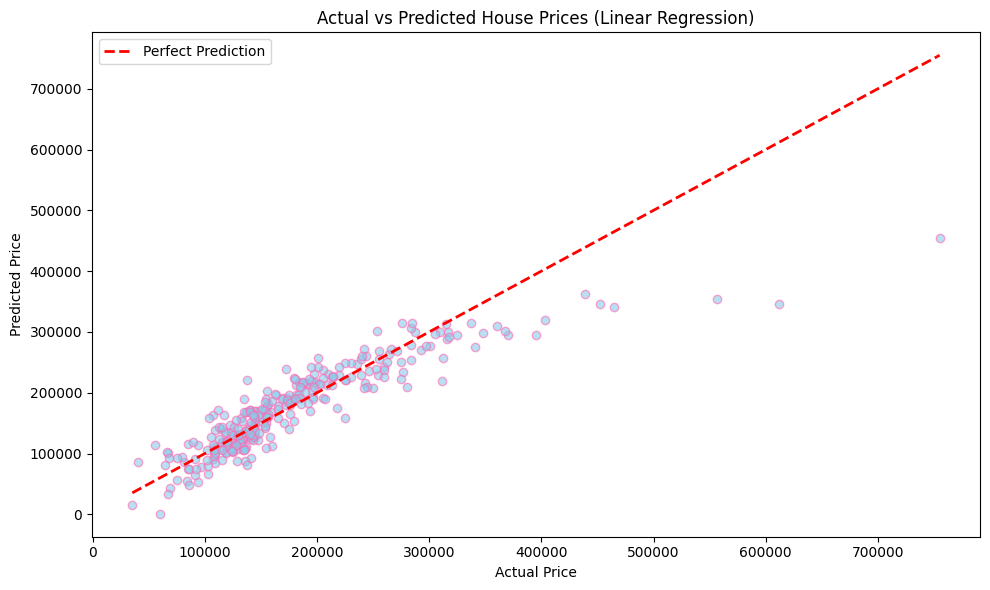

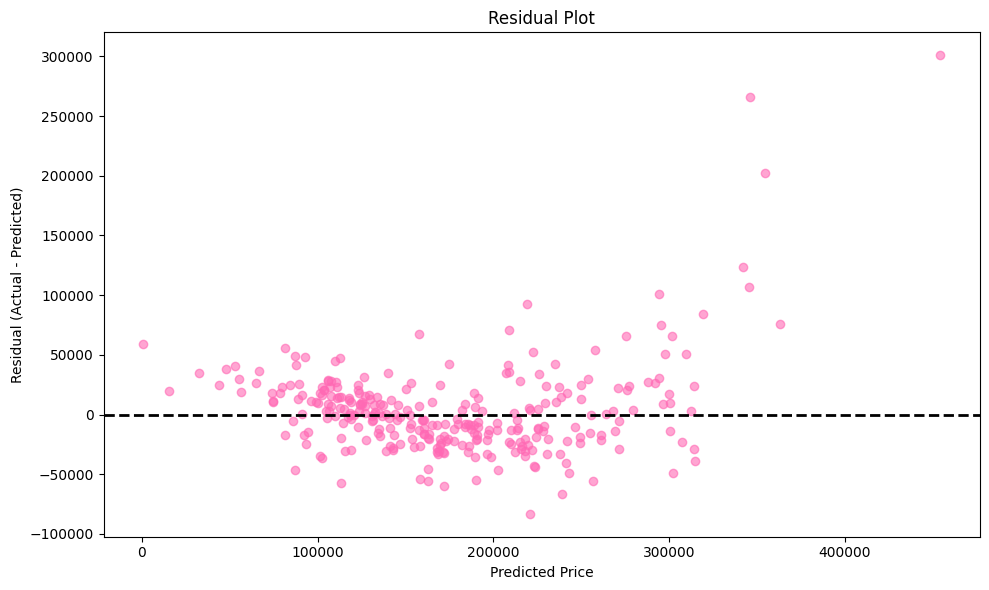

In [13]:
# Actual vs Predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, color='#87CEEB', edgecolors='#FF69B4')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted House Prices (Linear Regression)')
plt.legend()
plt.tight_layout()
plt.show()

# Residuals (errors)
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.6, color='#FF69B4')
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
plt.xlabel('Predicted Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

In [14]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Create and train Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    max_depth=15,          # Maximum depth of trees
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)

print("Training Random Forest... this may take a moment")
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# Evaluate
print("\nRANDOM FOREST RESULTS")
print("="*50)
print(f"Training R² Score: {r2_score(y_train, y_pred_train_rf):.4f}")
print(f"Testing R² Score: {r2_score(y_test, y_pred_test_rf):.4f}")
print(f"\nTesting RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_test_rf)):,.0f}")
print(f"Testing MAE: ${mean_absolute_error(y_test, y_pred_test_rf):,.0f}")

# Compare to Linear Regression
print("\nIMPROVEMENT vs Linear Regression:")
print(f"R² improvement: {r2_score(y_test, y_pred_test_rf) - r2_score(y_test, y_pred_test):.4f}")
rmse_improvement = np.sqrt(mean_squared_error(y_test, y_pred_test)) - np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
print(f"RMSE improvement: ${rmse_improvement:,.0f}")

Training Random Forest... this may take a moment

RANDOM FOREST RESULTS
Training R² Score: 0.9740
Testing R² Score: 0.8901

Testing RMSE: $29,037
Testing MAE: $19,165

IMPROVEMENT vs Linear Regression:
R² improvement: 0.0947
RMSE improvement: $10,577


Feature Importance:
        feature  importance
0   OverallQual    0.580567
1     GrLivArea    0.190483
3   TotalBsmtSF    0.106236
5     YearBuilt    0.044654
6  YearRemodAdd    0.035384
2    GarageCars    0.029234
4      FullBath    0.013442


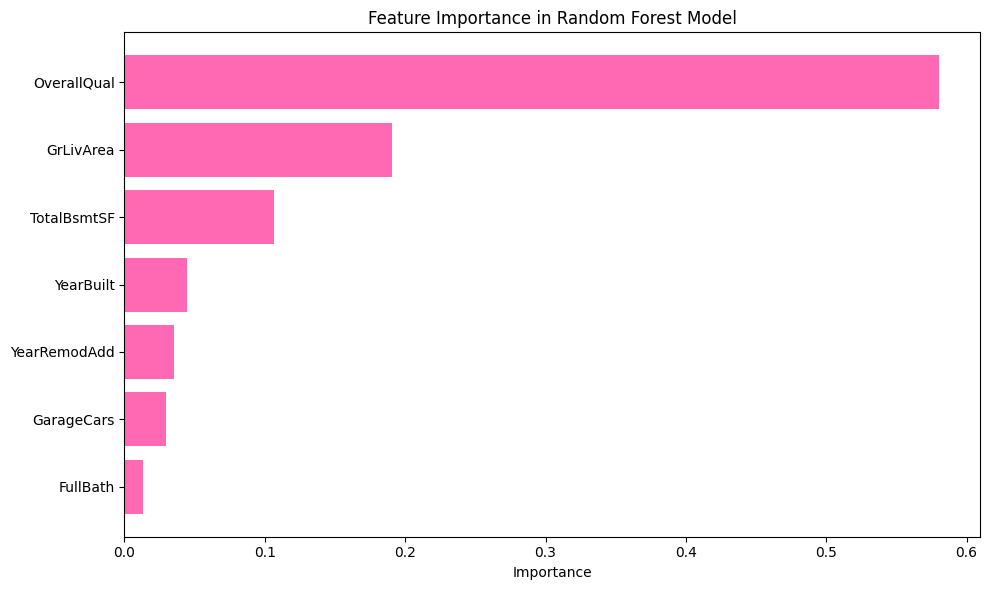

In [15]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': features_to_use,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Visualize it
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='#FF69B4')
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

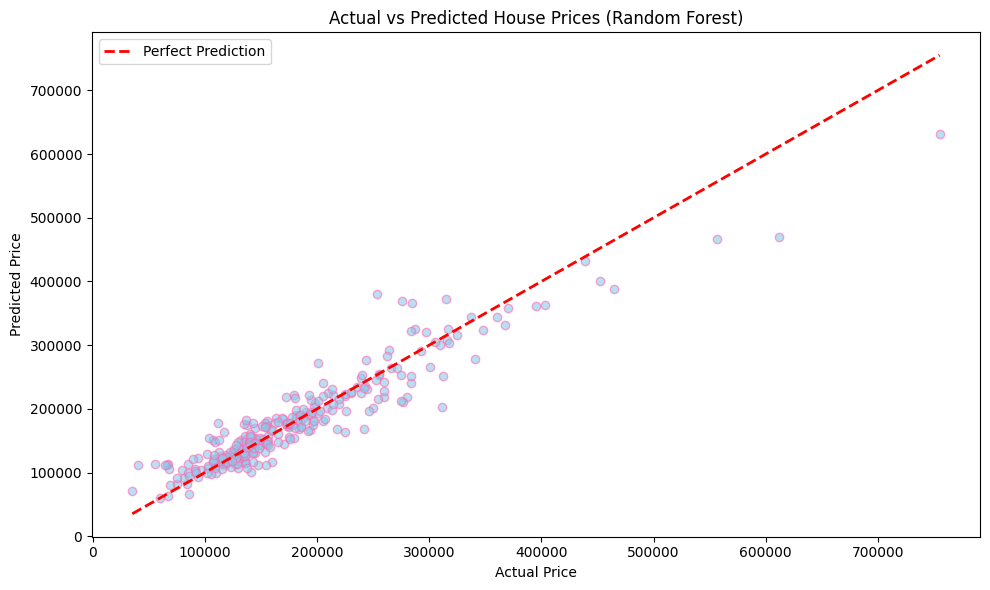

In [16]:
# Actual vs Predicted for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_rf, alpha=0.6, color='#87CEEB', edgecolors='#FF69B4')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted House Prices (Random Forest)')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Model comparison summary
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R² Score': [r2_score(y_test, y_pred_test), r2_score(y_test, y_pred_test_rf)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_test)),
             np.sqrt(mean_squared_error(y_test, y_pred_test_rf))],
    'MAE': [mean_absolute_error(y_test, y_pred_test),
            mean_absolute_error(y_test, y_pred_test_rf)]
})

print("\nFINAL MODEL COMPARISON")
print("="*60)
print(comparison.to_string(index=False))


FINAL MODEL COMPARISON
            Model  R² Score         RMSE          MAE
Linear Regression  0.795406 39614.453381 25155.936993
    Random Forest  0.890075 29037.175607 19165.239802


## Key Findings

1. **Random Forest significantly outperformed Linear Regression** (R² 0.89 vs 0.80)
2. **Overall Quality is the dominant predictor** (58% feature importance)
3. **Model achieved $29,037 RMSE** - average prediction within ~$29K of actual price
4. **Top 5 features** explain most price variation: Quality, Living Area, Garage, Basement


## Technologies Used
- Python (pandas, numpy, scikit-learn)
- Data Visualization (matplotlib, seaborn)
- Google Colab